In [1]:
# Import dependencies

In [2]:
# Reload modules whenever underlying code changes
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
from sgm.dependencies import *


Bad key savefig.frameon in file /home/mgaltier200/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/mgaltier200/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/mgaltier200/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably 

In [4]:
from sgm.envs import env_load_fn
from sgm.agent import UvfAgent
from sgm.trainer import train_eval
from sgm.envs import *
from scipy.spatial import distance
from sgm.evaluation import cleanup_and_eval
from sgm.planner import SoRBSearchPolicy
    
def generalized_difficulty(resize_factor):
    tf.reset_default_graph()

    # If you change the environment parameters below, make sure to run
    # tf.reset_default_graph() in the cell above before training.
    max_episode_steps = 20
    env_name = 'FourRooms'  # Choose one of the environments shown above. 
    resize_factor = resize_factor  # Inflate the environment to increase the difficulty.
    thin = True # If True, resize by expanding open space, not walls, to make walls thin
    desc_name = "thinned_" + env_name.lower() if thin else env_name.lower()

    base_dir = os.path.join(os.getcwd(), os.pardir, "agents")
    model_dir = os.path.join(base_dir, desc_name)

    tf_env = env_load_fn(env_name, max_episode_steps,
                         resize_factor=resize_factor,
                         terminate_on_timeout=False,
                         thin=thin)
    eval_tf_env = env_load_fn(env_name, max_episode_steps,
                              resize_factor=resize_factor,
                              terminate_on_timeout=True,
                              thin=thin)

    agent = UvfAgent(
        tf_env.time_step_spec(),
        tf_env.action_spec(),
        max_episode_steps=max_episode_steps,
        use_distributional_rl=True,
        ensemble_size=3)



    train_eval(agent,
              tf_env,
              eval_tf_env,
              initial_collect_steps=1000,
              eval_interval=1000,
              num_eval_episodes=10,
              num_iterations=30000,
              save_model_dir=model_dir,
              experiment_name=f"{resize_factor}_{env_name}_coordinate_{max_episode_steps}steps")

    filename = str(resize_factor)+"_FourRooms_coordinate_20steps-Dec-05-2019-12-58-28-PM/ckpt/"
    checkpoint_file = os.path.join(model_dir, filename)

    ckpt = tf.train.Checkpoint(step=tf.Variable(1), net=agent)
    manager = tf.train.CheckpointManager(ckpt, checkpoint_file, max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)

    #@title Fill the replay buffer with random data  {vertical-output: true, run: "auto" }
    replay_buffer_size = 2000 #@param {min:100, max: 1000, step: 100, type:"slider"}

    eval_tf_env.pyenv.envs[0].gym.set_sample_goal_args(
        prob_constraint=0.0,
        min_dist=0,
        max_dist=np.inf)
    rb_vec = []
    for it in range(replay_buffer_size):
        ts = eval_tf_env.reset()
        rb_vec.append(ts.observation['observation'].numpy()[0])
    rb_vec = np.array(rb_vec)


    plt.figure(figsize=(6, 6))
    plt.scatter(*rb_vec.T)
    plot_walls(eval_tf_env.pyenv.envs[0].env.walls)
    plt.show()

    pdist = agent._get_pairwise_dist(rb_vec, aggregate=None).numpy()

    plt.figure(figsize=(6, 3))
    plt.hist(pdist.flatten(), bins=range(20))
    plt.xlabel('predicted distance')
    plt.ylabel('number of (s, g) pairs')
    plt.show()

    euclidean_dists = distance.pdist(rb_vec)

    plt.figure(figsize=(6, 3))
    plt.hist(euclidean_dists.flatten())
    plt.xlabel('Euclidean distance')
    plt.ylabel('number of pairwise distances')
    plt.show()

    search_policy_type = "SoRB"
    agent.initialize_search(rb_vec, max_search_steps=6)
    search_policy = SoRBSearchPolicy(agent, pdist, rb_vec)


    logdir = os.path.join(os.getcwd(), os.pardir, "logs")
    eval_difficulty = 0.95
    k_nearest = 5
    eval_trials = 20
    total_cleanup_steps = 50000
    eval_period = 5000

    logfolder = cleanup_and_eval(search_policy,
                                 search_policy_type,
                                 desc_name,
                                 eval_tf_env,
                                 logdir,
                                 eval_difficulty=eval_difficulty,
                                 k_nearest=k_nearest,
                                 eval_trials=eval_trials,
                                 total_cleanup_steps=total_cleanup_steps,
                                 eval_period=eval_period)

/home/mgaltier200/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))



INFO:tensorflow:random_seed = 0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Saving checkpoints to directory /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt
INFO:tensorflow:Creating tensorboard summary writer with directory /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



  3%|▎         | 995/30000 [00:19<07:58, 60.62it/s] 

Saved checkpoint for step 1000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-1
INFO:tensorflow:step = 1000, loss = 2.328518
INFO:tensorflow:54.478 steps/sec
INFO:tensorflow:step = 1000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -16.40
INFO:tensorflow:		 predicted_dist = 14.2 (0.6)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -17.80
INFO:tensorflow:		 predicted_dist = 15.2 (0.3)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -19.70
INFO:tensorflow:		 predicted_dist = 15.7 (0.3)
INFO:tensorflow:	 eval_time = 3.98


  7%|▋         | 1999/30000 [00:39<08:34, 54.48it/s]  

Saved checkpoint for step 2000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-2
INFO:tensorflow:step = 2000, loss = 1.612936
INFO:tensorflow:66.423 steps/sec
INFO:tensorflow:step = 2000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -14.50
INFO:tensorflow:		 predicted_dist = 13.7 (2.9)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -19.20
INFO:tensorflow:		 predicted_dist = 16.6 (1.0)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -19.90
INFO:tensorflow:		 predicted_dist = 18.2 (0.5)
INFO:tensorflow:	 eval_time = 2.82


 10%|▉         | 2998/30000 [00:58<07:55, 56.84it/s]  

Saved checkpoint for step 3000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-3
INFO:tensorflow:step = 3000, loss = 1.242445
INFO:tensorflow:65.975 steps/sec
INFO:tensorflow:step = 3000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -9.90
INFO:tensorflow:		 predicted_dist = 16.3 (1.2)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -15.10
INFO:tensorflow:		 predicted_dist = 17.4 (1.2)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -20.00
INFO:tensorflow:		 predicted_dist = 18.1 (0.4)
INFO:tensorflow:	 eval_time = 2.62


 13%|█▎        | 3997/30000 [01:18<07:43, 56.08it/s]  

Saved checkpoint for step 4000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-4
INFO:tensorflow:step = 4000, loss = 1.121920
INFO:tensorflow:62.493 steps/sec
INFO:tensorflow:step = 4000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -13.90
INFO:tensorflow:		 predicted_dist = 15.9 (3.0)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -16.30
INFO:tensorflow:		 predicted_dist = 17.8 (1.3)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -19.30
INFO:tensorflow:		 predicted_dist = 18.5 (0.6)
INFO:tensorflow:	 eval_time = 2.95


 17%|█▋        | 4996/30000 [01:39<07:38, 54.51it/s]  

Saved checkpoint for step 5000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-5
INFO:tensorflow:step = 5000, loss = 1.289339
INFO:tensorflow:62.109 steps/sec
INFO:tensorflow:step = 5000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -10.10
INFO:tensorflow:		 predicted_dist = 14.9 (3.0)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -17.50
INFO:tensorflow:		 predicted_dist = 16.9 (0.9)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -18.30
INFO:tensorflow:		 predicted_dist = 18.5 (0.2)
INFO:tensorflow:	 eval_time = 2.79


 20%|█▉        | 5999/30000 [02:00<08:41, 46.01it/s]  

Saved checkpoint for step 6000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-6
INFO:tensorflow:step = 6000, loss = 1.876246
INFO:tensorflow:59.456 steps/sec
INFO:tensorflow:step = 6000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -6.90
INFO:tensorflow:		 predicted_dist = 13.4 (1.5)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -12.40
INFO:tensorflow:		 predicted_dist = 15.7 (1.0)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -18.50
INFO:tensorflow:		 predicted_dist = 17.1 (0.9)
INFO:tensorflow:	 eval_time = 3.05


 23%|██▎       | 6996/30000 [02:21<06:53, 55.58it/s]  

Saved checkpoint for step 7000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-7
INFO:tensorflow:step = 7000, loss = 2.251732
INFO:tensorflow:59.975 steps/sec
INFO:tensorflow:step = 7000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -6.40
INFO:tensorflow:		 predicted_dist = 11.3 (2.5)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -7.90
INFO:tensorflow:		 predicted_dist = 14.8 (1.2)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -18.20
INFO:tensorflow:		 predicted_dist = 17.1 (0.8)
INFO:tensorflow:	 eval_time = 2.78


 27%|██▋       | 7997/30000 [02:42<06:58, 52.53it/s]  

Saved checkpoint for step 8000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-8
INFO:tensorflow:step = 8000, loss = 2.617954
INFO:tensorflow:60.750 steps/sec
INFO:tensorflow:step = 8000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -5.00
INFO:tensorflow:		 predicted_dist = 9.0 (1.9)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -10.90
INFO:tensorflow:		 predicted_dist = 12.8 (1.3)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -17.40
INFO:tensorflow:		 predicted_dist = 15.2 (1.2)
INFO:tensorflow:	 eval_time = 2.63


 30%|██▉       | 8996/30000 [03:02<06:20, 55.16it/s]

Saved checkpoint for step 9000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-9
INFO:tensorflow:step = 9000, loss = 2.741106
INFO:tensorflow:60.013 steps/sec
INFO:tensorflow:step = 9000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -5.00
INFO:tensorflow:		 predicted_dist = 7.4 (1.2)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -11.40
INFO:tensorflow:		 predicted_dist = 11.6 (1.0)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -16.30
INFO:tensorflow:		 predicted_dist = 14.9 (0.8)
INFO:tensorflow:	 eval_time = 2.62


 33%|███▎      | 9994/30000 [03:23<05:51, 56.90it/s]

Saved checkpoint for step 10000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-10
INFO:tensorflow:step = 10000, loss = 2.943827
INFO:tensorflow:60.327 steps/sec
INFO:tensorflow:step = 10000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -3.80
INFO:tensorflow:		 predicted_dist = 6.1 (2.1)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -8.40
INFO:tensorflow:		 predicted_dist = 10.2 (0.9)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -15.90
INFO:tensorflow:		 predicted_dist = 14.2 (1.4)
INFO:tensorflow:	 eval_time = 2.31


 37%|███▋      | 10999/30000 [03:43<06:33, 48.30it/s]

Saved checkpoint for step 11000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-11
INFO:tensorflow:step = 11000, loss = 3.107904
INFO:tensorflow:60.691 steps/sec
INFO:tensorflow:step = 11000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -4.70
INFO:tensorflow:		 predicted_dist = 6.9 (1.3)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -9.50
INFO:tensorflow:		 predicted_dist = 10.3 (1.4)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -13.50
INFO:tensorflow:		 predicted_dist = 12.7 (1.3)
INFO:tensorflow:	 eval_time = 2.36


 40%|███▉      | 11994/30000 [04:04<05:31, 54.39it/s]

Saved checkpoint for step 12000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-12
INFO:tensorflow:step = 12000, loss = 3.285975
INFO:tensorflow:60.431 steps/sec
INFO:tensorflow:step = 12000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -4.90
INFO:tensorflow:		 predicted_dist = 5.8 (2.1)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -7.70
INFO:tensorflow:		 predicted_dist = 9.0 (1.6)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -15.30
INFO:tensorflow:		 predicted_dist = 12.5 (1.7)
INFO:tensorflow:	 eval_time = 2.44


 43%|████▎     | 12999/30000 [04:24<06:06, 46.38it/s]

Saved checkpoint for step 13000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-13
INFO:tensorflow:step = 13000, loss = 3.189516
INFO:tensorflow:60.865 steps/sec
INFO:tensorflow:step = 13000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -3.10
INFO:tensorflow:		 predicted_dist = 4.5 (1.9)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -8.20
INFO:tensorflow:		 predicted_dist = 9.1 (1.2)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -16.20
INFO:tensorflow:		 predicted_dist = 11.9 (1.6)
INFO:tensorflow:	 eval_time = 2.23


 47%|████▋     | 13999/30000 [04:44<06:06, 43.62it/s]

Saved checkpoint for step 14000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-14
INFO:tensorflow:step = 14000, loss = 3.818351
INFO:tensorflow:60.397 steps/sec
INFO:tensorflow:step = 14000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -2.20
INFO:tensorflow:		 predicted_dist = 3.9 (1.6)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -8.20
INFO:tensorflow:		 predicted_dist = 8.9 (1.2)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -14.10
INFO:tensorflow:		 predicted_dist = 11.2 (1.7)
INFO:tensorflow:	 eval_time = 2.47


 50%|████▉     | 14995/30000 [05:06<04:32, 55.14it/s]

Saved checkpoint for step 15000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-15
INFO:tensorflow:step = 15000, loss = 3.372180
INFO:tensorflow:57.322 steps/sec
INFO:tensorflow:step = 15000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -3.00
INFO:tensorflow:		 predicted_dist = 5.6 (1.2)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -10.40
INFO:tensorflow:		 predicted_dist = 8.0 (0.8)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -13.30
INFO:tensorflow:		 predicted_dist = 10.2 (1.3)
INFO:tensorflow:	 eval_time = 2.49


 53%|█████▎    | 15995/30000 [05:27<04:14, 55.08it/s]

Saved checkpoint for step 16000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-16
INFO:tensorflow:step = 16000, loss = 2.977075
INFO:tensorflow:57.312 steps/sec
INFO:tensorflow:step = 16000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -3.40
INFO:tensorflow:		 predicted_dist = 4.6 (1.3)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -10.40
INFO:tensorflow:		 predicted_dist = 8.4 (1.0)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -17.10
INFO:tensorflow:		 predicted_dist = 10.6 (1.1)
INFO:tensorflow:	 eval_time = 2.62


 57%|█████▋    | 16994/30000 [05:49<03:48, 57.00it/s]

Saved checkpoint for step 17000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-17
INFO:tensorflow:step = 17000, loss = 3.105785
INFO:tensorflow:56.140 steps/sec
INFO:tensorflow:step = 17000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -3.50
INFO:tensorflow:		 predicted_dist = 6.0 (1.5)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -8.40
INFO:tensorflow:		 predicted_dist = 8.5 (1.4)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -16.50
INFO:tensorflow:		 predicted_dist = 12.4 (1.4)
INFO:tensorflow:	 eval_time = 2.75


 60%|█████▉    | 17995/30000 [06:11<03:44, 53.52it/s]

Saved checkpoint for step 18000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-18
INFO:tensorflow:step = 18000, loss = 3.312252
INFO:tensorflow:56.600 steps/sec
INFO:tensorflow:step = 18000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -4.40
INFO:tensorflow:		 predicted_dist = 6.3 (1.8)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -10.00
INFO:tensorflow:		 predicted_dist = 9.7 (0.8)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -17.20
INFO:tensorflow:		 predicted_dist = 12.5 (1.7)
INFO:tensorflow:	 eval_time = 2.58


 63%|██████▎   | 18998/30000 [06:33<03:22, 54.33it/s]

Saved checkpoint for step 19000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-19
INFO:tensorflow:step = 19000, loss = 3.327999
INFO:tensorflow:55.553 steps/sec
INFO:tensorflow:step = 19000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -2.90
INFO:tensorflow:		 predicted_dist = 5.5 (1.9)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -7.40
INFO:tensorflow:		 predicted_dist = 8.5 (1.3)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -16.30
INFO:tensorflow:		 predicted_dist = 12.6 (1.2)
INFO:tensorflow:	 eval_time = 2.10


 67%|██████▋   | 19996/30000 [06:55<02:57, 56.37it/s]

Saved checkpoint for step 20000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-20
INFO:tensorflow:step = 20000, loss = 3.658300
INFO:tensorflow:56.742 steps/sec
INFO:tensorflow:step = 20000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -2.10
INFO:tensorflow:		 predicted_dist = 5.2 (1.6)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -9.20
INFO:tensorflow:		 predicted_dist = 8.9 (0.9)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -15.90
INFO:tensorflow:		 predicted_dist = 13.1 (1.6)
INFO:tensorflow:	 eval_time = 2.25


 70%|██████▉   | 20999/30000 [07:17<03:14, 46.39it/s]

Saved checkpoint for step 21000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-21
INFO:tensorflow:step = 21000, loss = 3.318485
INFO:tensorflow:56.053 steps/sec
INFO:tensorflow:step = 21000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -2.30
INFO:tensorflow:		 predicted_dist = 4.8 (1.5)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -10.30
INFO:tensorflow:		 predicted_dist = 8.6 (0.8)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -16.40
INFO:tensorflow:		 predicted_dist = 9.7 (2.2)
INFO:tensorflow:	 eval_time = 2.24


 73%|███████▎  | 21994/30000 [07:38<02:26, 54.77it/s]

Saved checkpoint for step 22000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-22
INFO:tensorflow:step = 22000, loss = 3.383037
INFO:tensorflow:56.392 steps/sec
INFO:tensorflow:step = 22000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -2.70
INFO:tensorflow:		 predicted_dist = 4.9 (1.8)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -8.60
INFO:tensorflow:		 predicted_dist = 8.3 (0.8)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -15.50
INFO:tensorflow:		 predicted_dist = 12.2 (1.9)
INFO:tensorflow:	 eval_time = 1.94


 77%|███████▋  | 22994/30000 [08:00<02:06, 55.58it/s]

Saved checkpoint for step 23000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-23
INFO:tensorflow:step = 23000, loss = 3.537915
INFO:tensorflow:54.991 steps/sec
INFO:tensorflow:step = 23000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -4.50
INFO:tensorflow:		 predicted_dist = 5.5 (1.5)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -7.10
INFO:tensorflow:		 predicted_dist = 8.5 (1.1)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -15.70
INFO:tensorflow:		 predicted_dist = 10.7 (1.3)
INFO:tensorflow:	 eval_time = 2.00


 80%|███████▉  | 23996/30000 [08:22<01:51, 53.73it/s]

Saved checkpoint for step 24000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-24
INFO:tensorflow:step = 24000, loss = 3.144258
INFO:tensorflow:54.961 steps/sec
INFO:tensorflow:step = 24000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -4.10
INFO:tensorflow:		 predicted_dist = 5.6 (1.6)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -6.90
INFO:tensorflow:		 predicted_dist = 9.0 (0.8)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -16.70
INFO:tensorflow:		 predicted_dist = 11.8 (0.8)
INFO:tensorflow:	 eval_time = 2.63


 83%|████████▎ | 24998/30000 [08:44<01:33, 53.66it/s]

Saved checkpoint for step 25000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-25
INFO:tensorflow:step = 25000, loss = 3.135751
INFO:tensorflow:55.356 steps/sec
INFO:tensorflow:step = 25000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -3.10
INFO:tensorflow:		 predicted_dist = 4.4 (1.7)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -8.70
INFO:tensorflow:		 predicted_dist = 8.8 (1.0)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -16.90
INFO:tensorflow:		 predicted_dist = 11.9 (1.2)
INFO:tensorflow:	 eval_time = 1.92


 87%|████████▋ | 25996/30000 [09:06<01:17, 51.49it/s]

Saved checkpoint for step 26000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-26
INFO:tensorflow:step = 26000, loss = 2.903501
INFO:tensorflow:55.374 steps/sec
INFO:tensorflow:step = 26000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -3.60
INFO:tensorflow:		 predicted_dist = 4.4 (1.5)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -10.70
INFO:tensorflow:		 predicted_dist = 8.4 (1.3)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -14.80
INFO:tensorflow:		 predicted_dist = 12.4 (2.0)
INFO:tensorflow:	 eval_time = 2.20


 90%|████████▉ | 26998/30000 [09:28<00:57, 51.77it/s]

Saved checkpoint for step 27000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-27
INFO:tensorflow:step = 27000, loss = 3.384498
INFO:tensorflow:56.050 steps/sec
INFO:tensorflow:step = 27000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -4.20
INFO:tensorflow:		 predicted_dist = 5.2 (1.8)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -9.20
INFO:tensorflow:		 predicted_dist = 9.2 (1.5)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -16.30
INFO:tensorflow:		 predicted_dist = 12.2 (1.7)
INFO:tensorflow:	 eval_time = 2.11


 93%|█████████▎| 27995/30000 [09:49<00:33, 59.01it/s]

Saved checkpoint for step 28000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-28
INFO:tensorflow:step = 28000, loss = 3.157752
INFO:tensorflow:55.747 steps/sec
INFO:tensorflow:step = 28000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -2.80
INFO:tensorflow:		 predicted_dist = 3.9 (1.5)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -8.70
INFO:tensorflow:		 predicted_dist = 8.0 (1.3)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -16.20
INFO:tensorflow:		 predicted_dist = 12.0 (1.6)
INFO:tensorflow:	 eval_time = 2.30


 97%|█████████▋| 28996/30000 [10:11<00:16, 60.62it/s]

Saved checkpoint for step 29000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-29
INFO:tensorflow:step = 29000, loss = 2.950235
INFO:tensorflow:55.619 steps/sec
INFO:tensorflow:step = 29000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -4.50
INFO:tensorflow:		 predicted_dist = 4.5 (1.5)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -8.00
INFO:tensorflow:		 predicted_dist = 6.8 (1.1)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -13.90
INFO:tensorflow:		 predicted_dist = 11.9 (1.4)
INFO:tensorflow:	 eval_time = 2.12


100%|█████████▉| 29999/30000 [10:33<00:00, 48.46it/s]

Saved checkpoint for step 30000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/3_FourRooms_coordinate_20steps-May-17-2021-09-07-50-PM/ckpt/ckpt-30
INFO:tensorflow:step = 30000, loss = 2.923357
INFO:tensorflow:57.130 steps/sec
INFO:tensorflow:step = 30000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -3.30
INFO:tensorflow:		 predicted_dist = 4.6 (1.4)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -9.70
INFO:tensorflow:		 predicted_dist = 8.2 (1.2)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -18.00
INFO:tensorflow:		 predicted_dist = 13.1 (1.2)
INFO:tensorflow:	 eval_time = 2.22


100%|██████████| 30000/30000 [10:35<00:00, 47.21it/s]


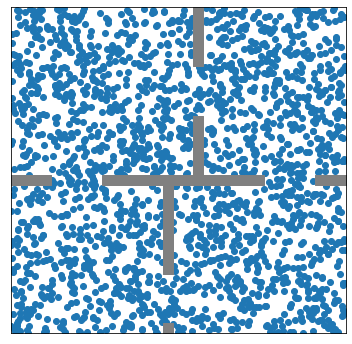

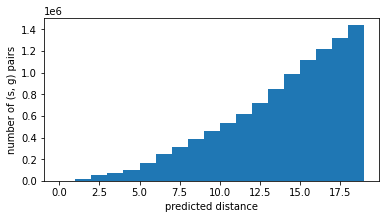

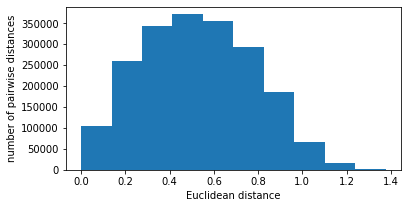

SoRB has initial success rate 0.05
Evaluated initial SoRB success rate in 816.02 seconds
After filtering and 0 cleanup steps, SoRB has success rate 0.20
Took 5000 cleanup steps and evaluated SoRB success rate in 6556.23 seconds
After filtering and 5000 cleanup steps, SoRB has success rate 0.00
Took 5000 cleanup steps and evaluated SoRB success rate in 7344.65 seconds
After filtering and 10000 cleanup steps, SoRB has success rate 0.40
Took 5000 cleanup steps and evaluated SoRB success rate in 8467.16 seconds
After filtering and 15000 cleanup steps, SoRB has success rate 0.20
Took 5000 cleanup steps and evaluated SoRB success rate in 8194.88 seconds
After filtering and 20000 cleanup steps, SoRB has success rate 0.70
Took 5000 cleanup steps and evaluated SoRB success rate in 7716.80 seconds
After filtering and 25000 cleanup steps, SoRB has success rate 0.45
Took 5000 cleanup steps and evaluated SoRB success rate in 7698.29 seconds
After filtering and 30000 cleanup steps, SoRB has success 

In [5]:
generalized_difficulty(3)